# Disaster Tweets

Classify tweets about disasters

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

print(tf.__version__)

2.11.0


In [3]:
df = pd.read_csv('../../datasets/disaster_tweets/train.csv')
df = df[['text', 'target']]
df = df.rename(columns={"target": "label"})

In [4]:
df.head()

,text,label
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: >

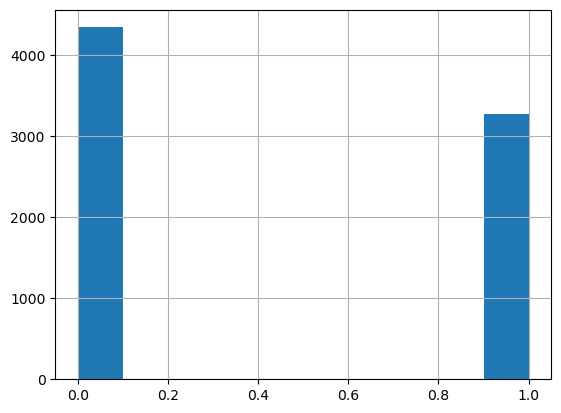

In [5]:
df['label'].hist()

In [6]:
max_features = 1500
df_train, df_test = train_test_split(df, random_state=42)
vectorizer = CountVectorizer(max_features=max_features)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

Y_train = np.array(df_train['label'])
Y_test = np.array(df_test['label'])

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 1)                 1501      
                                                                 
 dense_46 (Dense)            (None, 1)                 2         
                                                                 
Total params: 1,503
Trainable params: 1,503
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3000
12/12 [==============================] - 0s 10ms/step - loss: 0.7019 - binary_accuracy: 0.5695 - val_loss: 0.6995 - val_binary_accuracy: 0.5730
Epoch 2/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.7007 - binary_accuracy: 0.5695 - val_loss: 0.6984 - val_binary_accuracy: 0.5730
Epoch 3/3000
12/12 [==============================] - 0s 3ms/step - loss: 0.6995 - binary_accuracy: 0.5695 - val_loss: 0.6974 - v

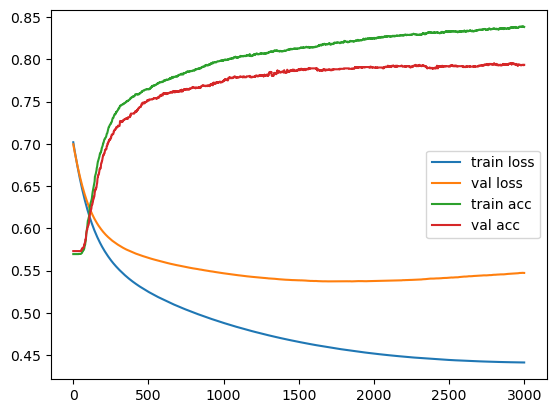

In [49]:
# input dimensions
D = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(D,), kernel_regularizer=L2(l2=0.003), bias_regularizer=L2(l2=0.003)),
    tf.keras.layers.Dense(1, input_shape=(D,), kernel_regularizer=L2(l2=0.003), bias_regularizer=L2(l2=0.03)),
    # tf.keras.layers.Dense(4, kernel_regularizer=L2(l2=0.01), bias_regularizer='l2', input_shape=(D,), activation='relu'),
    # tf.keras.layers.Dense(2, kernel_regularizer=L2(l2=0.01), bias_regularizer='l2', input_shape=(D,), activation='relu'),
    # tf.keras.layers.Dense(1, activation='softmax'),
])

print(model.summary())

model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.0001),
  metrics=[tf.keras.metrics.BinaryAccuracy()],
)

r = model.fit(
  X_train, Y_train,
  validation_data=(X_test, Y_test),
  epochs=3000,
  batch_size=512,
)

# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

# Plot accuracy per iteration
plt.plot(r.history['binary_accuracy'], label='train acc')
plt.plot(r.history['val_binary_accuracy'], label='val acc')
plt.legend();

# Test
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

print('F1-score:', f1_score(Y_test, P_test))

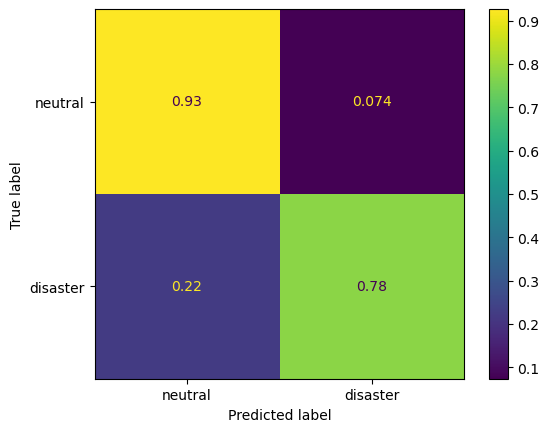

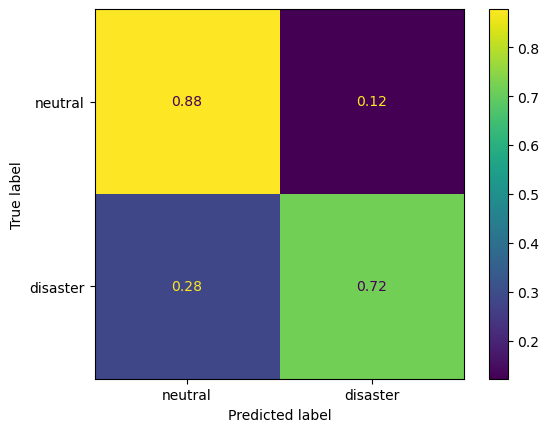

In [50]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['neutral', 'disaster'])
disp_train.plot()
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['neutral', 'disaster'])
disp_test.plot()

## Predict Results

In [51]:
df_results = pd.read_csv('../../datasets/disaster_tweets/test.csv')
X_r = vectorizer.transform(df_results['text'])
X_r = X_r.toarray()

In [52]:
P_r = ((model.predict(X_r) > 0) * 1).flatten()

102/102 [==============================] - 0s 374us/step


In [53]:
results = df_results[['id']]
results.insert(1, 'target', P_r)
results.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [54]:
results.to_csv("./disaster_predictions.csv", encoding='utf-8', index=False)

# Use BERT and HuggingFace

In [1]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoConfig, TrainingArguments, AutoModelForSequenceClassification, Trainer, pipeline
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchinfo import summary

import numpy as np
import pandas as pd

/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_csv('../../datasets/disaster_tweets/train.csv')
df_train = df_train[['text', 'target']]
df_train = df_train.rename(columns={"target": "label", 'text':'sentence'})
df_train.to_csv('../../datasets/disaster_tweets/BERT_train.csv', index=None)

df_test = pd.read_csv('../../datasets/disaster_tweets/test.csv')
df_test = df_test[['text']]
df_test = df_test.rename(columns={'text':'sentence'})
df_test.to_csv('../../datasets/disaster_tweets/BERT_test.csv', index=None)

In [3]:
train_dataset = load_dataset('csv', data_files='../../datasets/disaster_tweets/BERT_train.csv')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 710.54it/s]
Generating train split: 0 examples [00:00, ? examples/s]/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
Generating train split: 7613 examples [00:00, 450955.21 examples/s]


In [4]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 7613
    })
})

In [5]:
split = train_dataset['train'].train_test_split(test_size=0.1, seed=42)

### Load Model

In [6]:
checkpoint = 'bert-large-uncased' #'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 15.5kB/s]
config.json: 100%|██████████| 571/571 [00:00<00:00, 1.86MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 2.37MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 9.50MB/s]


In [7]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

tokenized_datasets = split.map(tokenize_fn, batched=True)

Map: 100%|██████████| 762/762 [00:00<00:00, 48393.62 examples/s]


In [8]:
config = AutoConfig.from_pretrained(checkpoint)
target_map = {'other': 0, 'disaster': 1}
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map
print(config.id2label)
print(config.label2id)

{0: 'other', 1: 'disaster'}
{'other': 0, 'disaster': 1}


In [9]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

model.safetensors: 100%|██████████| 1.34G/1.34G [02:54<00:00, 7.69MB/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              31,254,528
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,050
Total params:

In [25]:
training_args = TrainingArguments(
  output_dir='disaster_prediction_trainer',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=5,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

                                                  
 20%|██        | 429/2145 [03:49<13:44,  2.08it/s]

{'eval_loss': 0.48177939653396606, 'eval_accuracy': 0.8083989501312336, 'eval_f1': 0.7997912467607255, 'eval_runtime': 5.5239, 'eval_samples_per_second': 137.946, 'eval_steps_per_second': 2.172, 'epoch': 1.0}


 23%|██▎       | 500/2145 [04:29<13:34,  2.02it/s]  

{'loss': 0.4313, 'learning_rate': 3.834498834498835e-05, 'epoch': 1.17}


                                                  
 40%|████      | 858/2145 [07:49<10:22,  2.07it/s]

{'eval_loss': 0.5405387282371521, 'eval_accuracy': 0.800524934383202, 'eval_f1': 0.7917987877219095, 'eval_runtime': 6.3385, 'eval_samples_per_second': 120.218, 'eval_steps_per_second': 1.893, 'epoch': 2.0}


 47%|████▋     | 1000/2145 [09:12<10:20,  1.84it/s] 

{'loss': 0.4909, 'learning_rate': 2.6689976689976692e-05, 'epoch': 2.33}


                                                   
 60%|██████    | 1287/2145 [12:00<06:47,  2.11it/s]

{'eval_loss': 0.5091909766197205, 'eval_accuracy': 0.7979002624671916, 'eval_f1': 0.7870504119333648, 'eval_runtime': 6.3177, 'eval_samples_per_second': 120.614, 'eval_steps_per_second': 1.899, 'epoch': 3.0}


 62%|██████▏   | 1338/2145 [12:32<08:43,  1.54it/s]

KeyboardInterrupt: 

### We take the best model from the best f1-score epoch

In [12]:
disaster_model = pipeline('text-classification',
                      model='disaster_prediction_trainer/checkpoint-1287',
                      device='mps')

In [13]:
test_pred = disaster_model(split['test']['sentence'])

In [14]:
test_pred[0:3]

[{'label': 'disaster', 'score': 0.9710727334022522},
 {'label': 'other', 'score': 0.8660871386528015},
 {'label': 'disaster', 'score': 0.9649932384490967}]

In [15]:
test_pred = [d['label'] for d in test_pred]

In [16]:
test_labels = [config.id2label[x] for x in split['test']['label']]
test_labels[0:3]

['disaster', 'other', 'disaster']

In [17]:
print("acc:", accuracy_score(test_labels, test_pred))
print("f1-score:", f1_score(test_labels, test_pred, average='macro'))

acc: 0.8451443569553806
f1-score: 0.8364176193629609


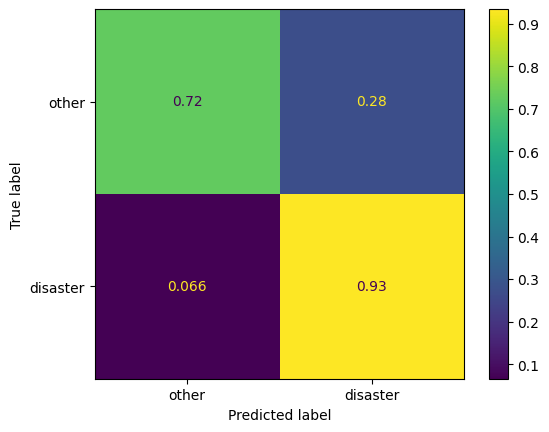

In [18]:
cm = confusion_matrix(test_labels, test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['other', 'disaster'])
disp.plot()

### Now evaluation on test set

In [19]:
eval_data = load_dataset('csv', data_files='../../datasets/disaster_tweets/BERT_test.csv')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 515.46it/s]
Generating train split: 0 examples [00:00, ? examples/s]/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
Generating train split: 3263 examples [00:00, 330500.22 examples/s]


In [20]:
eval_data

DatasetDict({
    train: Dataset({
        features: ['sentence'],
        num_rows: 3263
    })
})

In [21]:
eval_pred = disaster_model(eval_data['train']['sentence'])

In [22]:
eval_pred = [config.label2id[d['label']] for d in eval_pred]
eval_pred[0:3]

[1, 1, 1]

In [23]:
df_results = pd.read_csv('../../datasets/disaster_tweets/test.csv')
results = df_results[['id']]
results.insert(1, 'target', eval_pred)
results.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [24]:
results.to_csv("./disaster_predictions_BERT.csv", encoding='utf-8', index=False)